In [1]:
import os
from kgcnn.data.moleculenet import MoleculeNetDataset
from kgcnn.mol.molgraph import OneHotEncoder

In [2]:
os.makedirs("ExampleMol", exist_ok=True)
csv_data = "smiles,Values1,Values2\nCCC, 1, 0.1\nCCCO, 2, 0.3\nCCCN, 3, 0.2\nCCCC=O, 4, 0.4\n"
with open("ExampleMol/data.csv", "w") as f:
    f.write(csv_data)

To load the dataset from memeory the ``MoleculeNetDataset`` class requires the information of the directory the data is in and the name of the csv-file. Also recommended is to provide a name of the dataset.

In [3]:
dts = MoleculeNetDataset(file_name="data.csv", data_directory="ExampleMol/", dataset_name="ExampleMol",)

Precompute molecular features and cache the information to file in the same folder as provided in the class initialization.

In [4]:
dts.prepare_data(overwrite=True, smiles_column_name="smiles", make_conformers=True)

INFO:kgcnn: Generating molecules and store mol.json to disk...
 ... converted molecules 0 from 4
done


After ``prepare_data()`` is called, the cached mol-file can be read directly from the data-directory.

In [5]:
dts.read_in_memory(label_column_name="Values1", add_hydrogen=False)

INFO:kgcnn: Read mol-blocks from mol.json of pre-computed structures...
 ... read molecules 0 from 4
done


In [6]:
import networkx as nx
import rdkit.Chem as Chem

In [7]:
dts.node_number, dts.node_symbol

([array([6, 6, 6]),
  array([6, 6, 6, 8]),
  array([6, 6, 6, 7]),
  array([6, 6, 6, 6, 8])],
 [['C', 'C', 'C'],
  ['C', 'C', 'C', 'O'],
  ['C', 'C', 'C', 'N'],
  ['C', 'C', 'C', 'C', 'O']])

In [8]:
dts.edge_indices, dts.edge_number

([array([[0, 1],
         [1, 0],
         [1, 2],
         [2, 1]], dtype=int64),
  array([[0, 1],
         [1, 0],
         [1, 2],
         [2, 1],
         [2, 3],
         [3, 2]], dtype=int64),
  array([[0, 1],
         [1, 0],
         [1, 2],
         [2, 1],
         [2, 3],
         [3, 2]], dtype=int64),
  array([[0, 1],
         [1, 0],
         [1, 2],
         [2, 1],
         [2, 3],
         [3, 2],
         [3, 4],
         [4, 3]], dtype=int64)],
 [array([[1],
         [1],
         [1],
         [1]]),
  array([[1],
         [1],
         [1],
         [1],
         [1],
         [1]]),
  array([[1],
         [1],
         [1],
         [1],
         [1],
         [1]]),
  array([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [2],
         [2]])])

In [9]:
G = nx.Graph()
G.add_nodes_from([(i, {"atom": x}) for i, x in enumerate(dts.node_symbol[3])])
G.add_edges_from(dts.edge_indices[3])

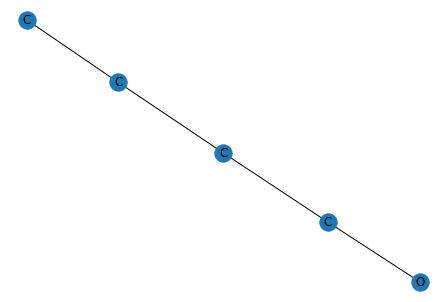

In [10]:
labels = nx.get_node_attributes(G, 'atom') 
nx.draw(G,labels=labels)

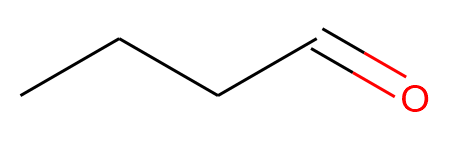

In [11]:
Chem.MolFromSmiles("CCCC=O")

Adding further attributes from rdkit is possible using the ``set_attributes`` method

In [12]:
dts.set_attributes(nodes=["Symbol", "TotalNumHs"], encoder_nodes = {"Symbol": OneHotEncoder(["C", "N", "O"], dtype="str", add_unknown=False)},
                   edges=["BondType", "Stereo"], encoder_edges = {"BondType": int},
                   graph=["ExactMolWt"]
                  )

INFO:kgcnn: Making attributes...
 ... read molecules 0 from 4
done
INFO:kgcnn: OneHotEncoder Symbol found ['C', 'O', 'N']


In [13]:
dts.node_attributes

[array([[1., 0., 0., 3.],
        [1., 0., 0., 2.],
        [1., 0., 0., 3.]], dtype=float32),
 array([[1., 0., 0., 3.],
        [1., 0., 0., 2.],
        [1., 0., 0., 2.],
        [0., 0., 1., 1.]], dtype=float32),
 array([[1., 0., 0., 3.],
        [1., 0., 0., 2.],
        [1., 0., 0., 2.],
        [0., 1., 0., 2.]], dtype=float32),
 array([[1., 0., 0., 3.],
        [1., 0., 0., 2.],
        [1., 0., 0., 2.],
        [1., 0., 0., 1.],
        [0., 0., 1., 0.]], dtype=float32)]

In [14]:
dts.edge_attributes

[array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]], dtype=float32),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [2., 0.],
        [2., 0.]], dtype=float32)]

In [15]:
dts.graph_attributes

[array([44.0626], dtype=float32),
 array([60.057514], dtype=float32),
 array([59.073498], dtype=float32),
 array([72.05752], dtype=float32)]